## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
import embodied as emg
import embodied_indep as emi
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate


importlib.reload(MGME) 
importlib.reload(emg)
importlib.reload(emi)


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'
#tensorboard --logdir=mingame_worker_1:'<...>'

## Setup k-vs-(N-k) Mingame Env

In [3]:
importlib.reload(MGME)

<module 'minoritygame.minority_multienv' from '/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/minoritygame/minority_multienv.py'>

In [4]:
n_agents = 61

exos = (np.random.sample(n_agents) < 0.3)  # np.sum(exos)
exos = [True, True, False, False]
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

4 2 [0, 1]
3 1


In [5]:
len(menv.actor_exoQ), (len(menv.agents), menv.nagents)

(4, (4, 4))

## Setup MARL

In [6]:
num_episodes, n_epochs, max_len = (25, 501, 30)

In [7]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=2.)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,), out_dim=out_dim, gamma_reg=5.)

In [8]:
tf.reset_default_graph()
importlib.reload(emi)

<module 'embodied_indep' from './embodied_arch/embodied_indep.py'>

In [9]:
## REINFORCE
# embrf = emi.EmbodiedAgent_IRF(
#     name="mgRF_k-vs-N-k", env_=menv, latentDim=4,
#     actorNN=actor, sensorium=sensor, alpha=5.e-1,
#     max_episode_length=max_len
# )

## REINFORCE with Baseline
embrf = emi.EmbodiedAgent_IRFB(
    name="mgRFB_k-vs-N-k",
    env_=menv, latentDim=4, 
    alpha_p=5.e-1, alpha_v=1e-2, 
    actorNN=actor, valueNN=value,
    sensorium=sensor,
    max_episode_length=max_len
)

print(embrf, embrf.s_size, embrf.a_size)

<embodied_indep.EmbodiedAgent_IRFB object at 0x1c389b5210> 3 1


In [10]:
sess = tf.InteractiveSession()
embrf.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgRFB_k-vs-N-k


In [11]:
## Verify step + play set up
state = embrf.env.reset()
# print(state, embrf.act(state, sess))

embrf.play(sess)
np.sum(np.array(embrf.episode_buffer['rewards']), axis=0)
# np.array(embrf.episode_buffer['rewards'])

array([7., 7.])

In [12]:
print(embrf.last_total_returns)
print(emi.summarize_np(embrf.last_total_returns))

[7. 7.]
(7.0, 7.0, 7.0)


### Pre-test Agent

In [13]:
print('Baselining untrained pnet...')
rwd_mg0 = []
for k in range(num_episodes):
    embrf.play(sess, terminal_reward=0.)
    rwd_mg0.append(embrf.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf_mg = np.mean(np.array(rwd_mg0)/float(embrf.max_episode_length))
print("\nAgent wins an average of {} pct".format(100.0*base_perf_mg))

base_per_agent = np.mean(np.array(rwd_mg0)/float(embrf.max_episode_length), axis=0)

Baselining untrained pnet...
Episode 20/25
Agent wins an average of 23.73333333333333 pct


## Train MARL Agents

In [14]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
embrf.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent mgRFB_k-vs-N-k
Epoch no.: 0/501

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (2.0, 6.0, 10.0)
Losses/Policy LLs: (-2.945191, -0.43528622, -0.052137643)
Losses/Critic Scores: (-0.86334664, 0.47699833, 1.8843292)
Losses/Policy Entropies: (0.20086935, 0.39461735, 0.57634664)
Saved Model
Epoch no.: 100/501

	Stats @Step 100: 	(Min, Mean, Max)
Perf/Recent Rewards: (3.0, 7.5, 12.0)
Losses/Policy LLs: (-2.238146, -0.52603865, -0.107903875)
Losses/Critic Scores: (1.7856442, 3.3147087, 4.820733)
Losses/Policy Entropies: (0.3300772, 0.46566677, 0.6188556)
Saved Model
Epoch no.: 200/501

	Stats @Step 200: 	(Min, Mean, Max)
Perf/Recent Rewards: (30.0, 30.0, 30.0)
Losses/Policy LLs: (-0.0003829351, -0.00025083456, -0.00011873398)
Losses/Critic Scores: (14.248821, 14.292317, 14.335812)
Losses/Policy Entropies: (0.01, 0.01, 0.01)
Saved Model
Epoch no.: 300/501

	Stats @Step 300: 	(Min, Mean, Max)
Perf/Recent Rewards: (30.0, 30.0, 30.0)
Losses/Policy LLs: (-7.7574

### Post-test Agent

In [15]:
# Test pnet!
print('Testing...')
rwd_mg = []
for k in range(num_episodes):
    embrf.play(sess, terminal_reward=0.)
    rwd_mg.append(embrf.last_total_returns)
    if k%int(num_episodes/5) == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf_mg = np.mean(np.array(rwd_mg)/float(embrf.max_episode_length))
print("\nAgent wins an average of {} pct compared to baseline of {} pct".format(
    100*trained_perf_mg, 100*base_perf_mg) )

trained_per_agent = np.mean(np.array(rwd_mg)/float(embrf.max_episode_length), axis=0)

Testing...
Episode 20/25
Agent wins an average of 100.0 pct compared to baseline of 23.73333333333333 pct



Agent wins an average of 100.0 pct 
compared to baseline of 23.73333333333333 pct


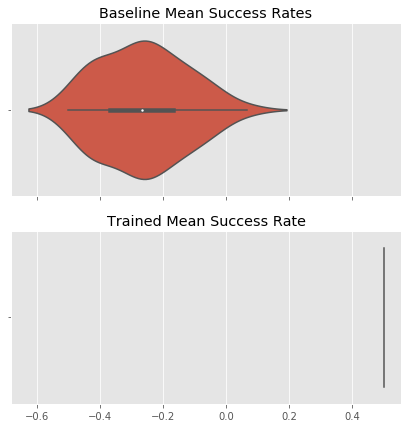

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(np.array(rwd_mg0)/embrf.max_episode_length - 0.5, ax = axs[0])
axs[0].set_title('Baseline Mean Success Rates')
sns.violinplot(np.array(rwd_mg)/embrf.max_episode_length - 0.5, ax = axs[1])
axs[1].set_title('Trained Mean Success Rate')

print("\nAgent wins an average of {} pct \ncompared to baseline of {} pct".format(
    100*trained_perf_mg, 100*base_perf_mg) )

<BarContainer object of 2 artists>

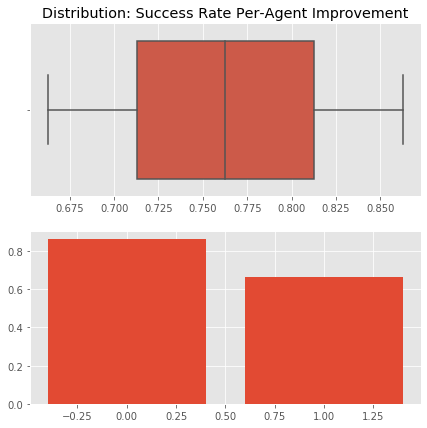

In [17]:
fig, axs = plt.subplots(2,1)
cmp = sns.boxplot(trained_per_agent-base_per_agent, ax = axs[0])
axs[0].set_title('Distribution: Success Rate Per-Agent Improvement');
axs[1].bar(x=range(sum(exos)), height=(trained_per_agent-base_per_agent))

In [18]:
embrf.last_good_model

'./log/train_mgRFB_k-vs-N-k/model-500.cptk'